In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
cnt = 2
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        cnt = cnt - 1
        if (cnt == 0):
            break
    if (cnt == 0):
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best_model_arch1_2.keras/keras/default/1/model_checkpoint_arch1_2.keras
/kaggle/input/best_transfer_learning_model/keras/default/1/model_checkpoint_transfer_learning.keras


## Problem Statement

The goal of this project is to develop a machine learning model that can accurately detect the presence of metastatic cancer in histopathologic tissue images. Specifically, the task involves classifying small image patches extracted from whole-slide images of lymph node sections as either:

1 (tumor) — indicating the presence of metastatic cancer cells

0 (no tumor) — indicating the absence of cancer cells

Accurate classification of these patches plays a critical role in cancer diagnosis and staging, which is essential for determining patient treatment plans. Given the high resolution and complexity of medical images, automated methods can greatly aid pathologists by improving speed, consistency, and accuracy of diagnosis.

In [3]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd

## EDA

In [5]:
train_files = os.listdir(train_dir)
print ('train files', len(train_files))

train files 220025


In [6]:
test_files = os.listdir(test_dir)
print('test files', len(test_files))

test files 57458


Dataset is divided in 2 datasets
1. Train dataset of size 220k
2. Test dataset of size 57k

Models will be trained on the train dataset whereas they will be tested on test dataset.

In [7]:
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_df.shape)

(220025, 2)


In [8]:
print(train_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


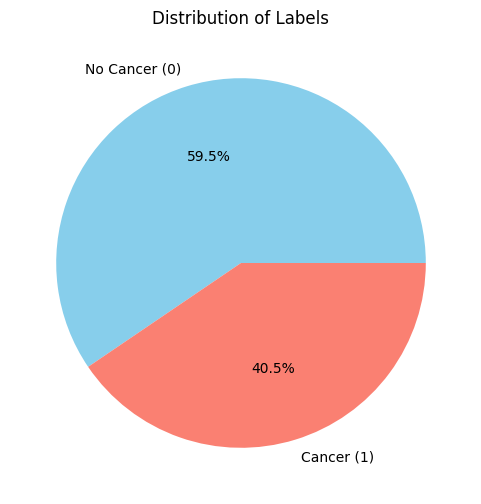

In [9]:
# Load dataset
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Count occurrences of each label
label_counts = train_df['label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['No Cancer (0)', 'Cancer (1)'], autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Distribution of Labels')
plt.show()


As can be seen in the pie chart, 40.5% of dataset corresponds to Cancer images vs 59.5% of dataset consists of Non cancer images. As its almost balanced, I am concluding we don't need extra processing to balance the dataset. Having said that, I will monitor model performance to ensure it does not get biased towards the majority class ie Non cancer.

This is useful info when training our model, I will provide more weightage to cancel (label=1) category images than to non cancer images. This will ensure model is not biased towards non cancerous images.

In [10]:
img_0 = cv2.imread(os.path.join(train_dir, train_files[0]))
img_0.shape

(96, 96, 3)

All images are of size 96x96 and have 3 channels (RGB)

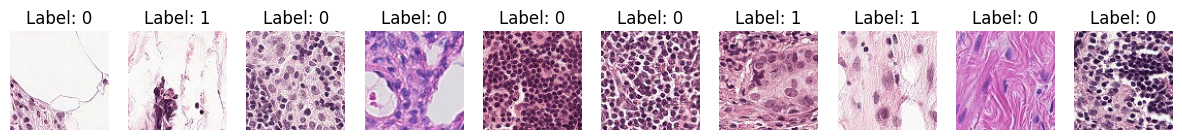

In [11]:
# Define dataset directory
train_dir = "/kaggle/input/histopathologic-cancer-detection/train/"

# Select first 5 image IDs
image_ids = train_df.iloc[:10]['id']

# Plot multiple images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # Create a row of 5 images

for idx, img_id in enumerate(image_ids):
    image_path = os.path.join(train_dir, img_id + ".tif")  # Construct image path
    image = Image.open(image_path)  # Open image
    
    # Display image
    axes[idx].imshow(image)
    axes[idx].axis('off')
    axes[idx].set_title(f"Label: {train_df.iloc[idx]['label']}")

plt.show()

Above shows the different images with labels 0 and 1. From naked eye its difficult to know the issue especially as i know nothing about cancer but looks like there is a lump of tissue in image 2 which could refer to it being cancerous.

### Preprocessing

As training dataset is too large (220k) and its too time consuming to train on such a large dataset, i am resampling the dataset to a smaller version of 30k images from each label, totalling to 60k images. This will also ensure both the labels are equally represented in the traiing dataset. The initiial spit showed its 40-60 split but now it will be 50-50.

In [12]:
### Resample dataset to 20k from each category so that its easier for training, 220k images are getting out of memory exception for kaggle notebook
TRAIN_SIZE_PER_LABEL=20000
negative = train_df[train_df['label'] == 0].sample(TRAIN_SIZE_PER_LABEL)
positive = train_df[train_df['label'] == 1].sample(TRAIN_SIZE_PER_LABEL)
neg_and_pos = pd.concat([negative, positive], axis=0).reset_index(drop=True)
train_df_small = neg_and_pos.sample(frac=1).reset_index(drop=True)

In [19]:
train_dir = "/kaggle/input/histopathologic-cancer-detection/train/"
def load_image(img_id=None, img_dir=train_dir, img_path=''):
    path = img_path
    if img_path == '':
        path = img_dir + img_id + '.tif'
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [17]:
X_normalised_path = '/kaggle/working/X_normalized.npy'
if os.path.exists(X_normalised_path) == False:
    X = np.array([load_image(img_id=img_id) for img_id in train_df_small['id']])
    y = train_df_small['label'].values
    # Compute the mean and std across the entire batch of images
    means = X.mean(axis=(0, 1, 2))  # Compute mean for each channel (R, G, B)
    stds = X.std(axis=(0, 1, 2))    # Compute std for each channel (R, G, B)
    
    print(f"Mean per channel: {means}")
    print(f"Standard Deviation per channel: {stds}")
    X_normalised = (X - means) / stds

In [ ]:
if os.path.exists(X_normalised_path) == False:
    import numpy as np
    
    # Save X and y as NumPy arrays
    np.save('/kaggle/working/X_normalized.npy', X_normalised)
    np.save('/kaggle/working/y.npy', y)
else:
    X_normalised = np.load('/kaggle/working/X_normalized.npy', mmap_mode='r')
    y = np.load('/kaggle/working/y.npy', mmap_mode='r')
    X = X_normalised * stds + means

In [14]:
X_normalised.shape

(40000, 96, 96, 3)

In [15]:
import sys
sys.getsizeof(X_normalised)

8847360160

In [16]:
X.shape

(40000, 96, 96, 3)

Now I am ready with the input for the model

## Model Building and Training

#### Theory and Plan


##### Architecture 1: Simple CNN model

This model will have following simple structure which has proved to work great in general problem space

(CNN -> CNN -> Max Pooling)n=5 where n = 5 means the basic struct is repeated 5 times


##### Architecture 2: Transfer learning
Here I will use pre trained model like EfficientNet. I will use the base model of EfficientNetB0 to understand the image but will fine tune my own classification layer on top of it for this problem.

#### Architecture 1: Simple CNN model

This model will have following simple structure which has proved to work great in general problem space

1. (CNN -> CNN -> Max Pooling)n=5 where n = 5 means the basic struct is repeated 5 times
2. Each hidden layer will have BatchNormalisation. Input is already normalised in preprocessing step.
3. Every hidden layer has ReLu activation function which has proven to work good for hiden layers.
4. I will have a Dense layer at the end of the architecture which will have a sigmoid activation layer. The output will give us a probability of the input image to be cancerous tissue or not. If model analyses with prob>0.5 for input image to be cancerous (label=1) we determine the predicted label to be 1 else it will be deduced to be 0.


A note: I ran the code in this module as part of version 5 of this notebook here - https://www.kaggle.com/code/anuragshah1/notebook9affbb3c0a?scriptVersionId=230260023. I will attach ss in the output blocks to avoid running the entire notebook together as it timesout.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define model
model_arch1 = Sequential()

# CNN Block 1
model_arch1.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(96, 96, 3)))
model_arch1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_arch1.add(BatchNormalization())
model_arch1.add(MaxPooling2D(pool_size=(2,2)))

# CNN Block 2
model_arch1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_arch1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_arch1.add(BatchNormalization())
model_arch1.add(MaxPooling2D(pool_size=(2,2)))

# CNN Block 3
model_arch1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_arch1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_arch1.add(BatchNormalization())
model_arch1.add(MaxPooling2D(pool_size=(2,2)))

# CNN Block 4
model_arch1.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_arch1.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_arch1.add(BatchNormalization())
model_arch1.add(MaxPooling2D(pool_size=(2,2)))

# CNN Block 5
model_arch1.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_arch1.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_arch1.add(BatchNormalization())
model_arch1.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected Layer
model_arch1.add(Flatten())
model_arch1.add(Dense(512, activation='relu'))
model_arch1.add(Dropout(0.5))
model_arch1.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model_arch1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "auc"])

# Summary
model_arch1.summary()


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint('model_checkpoint_arch1.keras', save_best_only=True)

batch_size = 32
epochs = 20

# # Train the model
# history = model_arch1.fit(
#     X_normalised,
#     y,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_split=0.2,
#     shuffle=True,
#     callbacks=[checkpoint_callback]
# )

I commented the above code but from the initial run, I was able to see, the model took 2 seconds / step, which amounts to 2(seconds/step)*20(steps/epoch)*1000(epochs) ~12 hours of training time. I will simplify the model and reduce the number of parameters so it finishes in reasonable time.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define model
model_arch1_2 = Sequential()

# CNN Block 1
model_arch1_2.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(96, 96, 3)))
model_arch1_2.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_arch1_2.add(BatchNormalization())
model_arch1_2.add(MaxPooling2D(pool_size=(2,2)))

# CNN Block 2
model_arch1_2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_arch1_2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_arch1_2.add(BatchNormalization())
model_arch1_2.add(MaxPooling2D(pool_size=(2,2)))

# CNN Block 3
model_arch1_2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_arch1_2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_arch1_2.add(BatchNormalization())
model_arch1_2.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected Layer
model_arch1_2.add(Flatten())
model_arch1_2.add(Dense(128, activation='relu'))
model_arch1_2.add(Dropout(0.5))
model_arch1_2.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model_arch1_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "auc"])

# Summary
model_arch1_2.summary()


As shown, I reduced couple of CNN layers and reduced dense layer to 128 neurons instead of 512 (making it a simpler model).

This reduced the parameters from ~7 million to ~2.6 million which is 37% of initial size. So we would expect 37% of initial time to train the model ~ 12 * 0.37 ~ 4.5 hours. I will further reduce the number of epochs to 10 so the time halves, final estimate ~4.5/2 = ~2.5 hours

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint('model_checkpoint_arch1_2.keras', save_best_only=True)

batch_size = 32
epochs = 20

model_load_path = '/kaggle/input/best_model_arch1_2.keras/keras/default/1/model_checkpoint_arch1_2.keras'
if (os.path.exists(model_load_path)):
    model_arch1_2 = load_model(model_load_path)
history = model_arch1_2.fit(
        X_normalised,
        y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        shuffle=True,
        callbacks=[checkpoint_callback]
    )

I ran tha above model in different versions of this notebook, hence I am attaching screen shots and links to the run.

Run - https://www.kaggle.com/code/anuragshah1/notebook9affbb3c0a/notebook?scriptVersionId=230367428


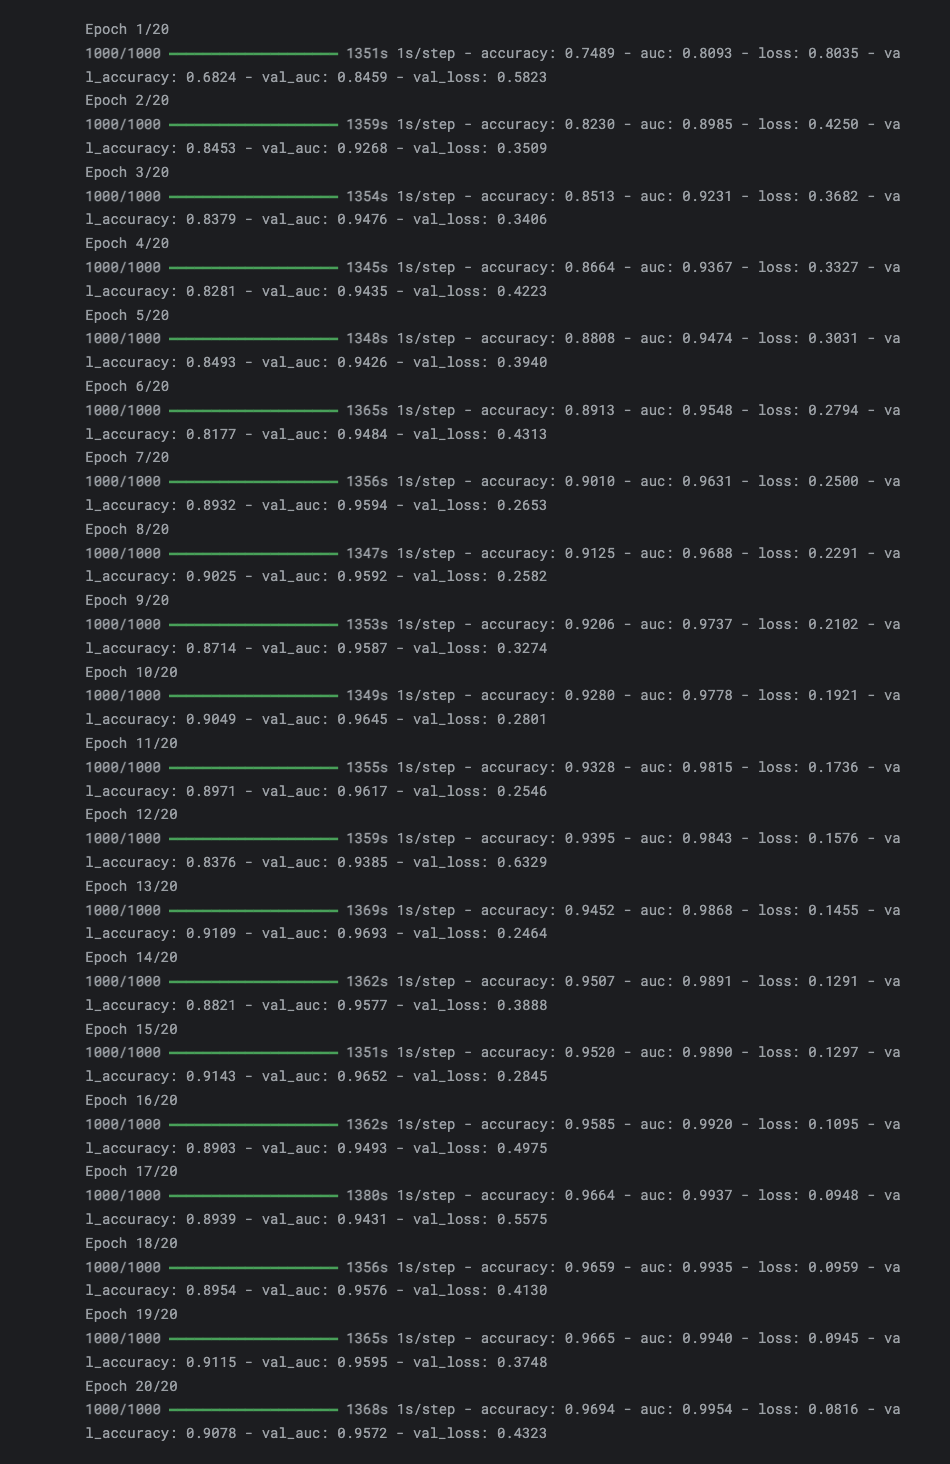

In [ ]:
# import matplotlib.pyplot as plt

# # Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


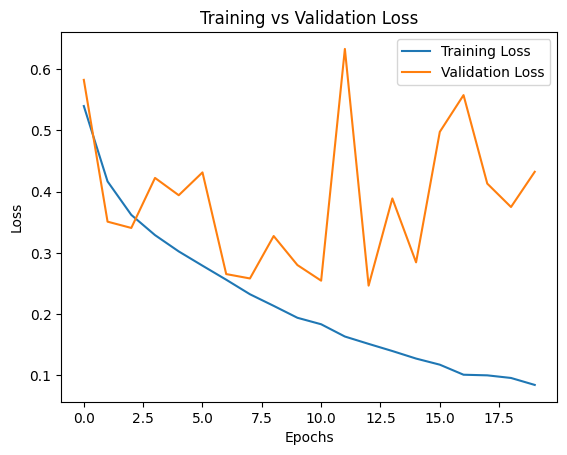
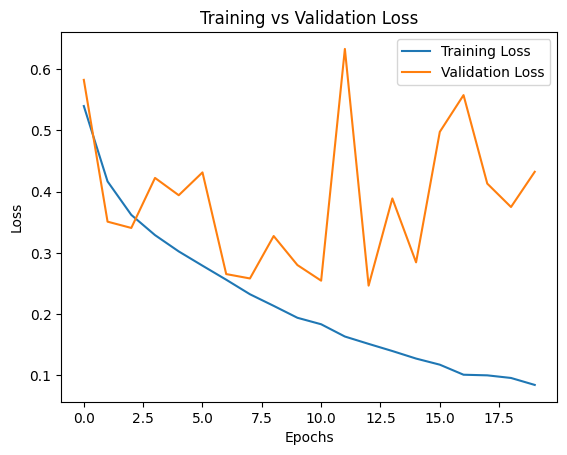

In [15]:
import os
import numpy as np
X_test_path = '/kaggle/working/X_test_normalized.npy'

# if not os.path.exists(X_test_path):
test_image_ids = [f[:-4] for f in os.listdir(test_dir) if f.endswith(".tif")]
X_test = np.array([load_image(img_id, test_dir) for img_id in test_image_ids])

In [16]:
### Test the model on test dataset and generate output. Submit it to competition and get results.
# Mean per channel: [179.09645477 138.07895266 177.63314542]
# Standard Deviation per channel: [59.77747839 70.58780024 53.95306808]
means = np.array([179.09645477, 138.07895266, 177.63314542])
stds = np.array([59.77747839, 70.58780024, 53.95306808])

# Apply the same normalization using the means and stds from training data
X_test_normalised = (X_test - means) / stds
# np.save(X_test_path, X_test_normalised)
# else:
#     X_test_normalised = np.load(X_test_path)



In [18]:
X_test_normalised_path = '/kaggle/working/X_test_normalised.npy'
if os.path.exists(X_test_normalised_path) == False:
    import numpy as np
    
    # Save X and y as NumPy arrays
    np.save(X_test_normalised_path, X_test_normalised)
else:
    X_test_normalised = np.load(X_test_normalised_path, mmap_mode='r')

In [ ]:
from tensorflow.keras.models import load_model

best_model_arch1_2 = load_model('/kaggle/input/best_model_arch1_2.keras/keras/default/1/model_checkpoint_arch1_2.keras')

In [ ]:
predictions = best_model_arch1_2.predict(X_test_normalised, batch_size=16)
y_pred = [1 if prediction > 0.5 else 0 for prediction in predictions]
print(y_pred[:5])

#### Architecture 2: Transfer learning
I will use pretrained weights of [EfficientNet](https://keras.io/api/applications/efficientnet/) model which is trained on imagenet dataset. I will add my own top layer and train it separately.

A note: I ran the code in this module as part of version 8 of this notebook here - https://www.kaggle.com/code/anuragshah1/notebook9affbb3c0a?scriptVersionId=230367428. I will attach ss in the output blocks to avoid running the entire notebook together as it timesout.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 without the top layer (fully connected layers)
base_model = EfficientNetB0(weights="/kaggle/input/efficientnetb0_notop/keras/default/1/efficientnetb0_notop.h5", 
                            include_top=False, 
                            input_shape=(96, 96, 3))
# Freeze all layers so they don't get updated during training
base_model.trainable = False

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Input

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(1, activation="sigmoid")(x)

# Create the final model
model_transfer_learning = Model(inputs=base_model.input, outputs=output_layer)
# model_transfer_learning.summary()

In [ ]:
model_transfer_learning.compile(optimizer=Adam(learning_rate=0.0001), 
                                loss="binary_crossentropy",
                                metrics=["accuracy", "AUC"])

In [ ]:
history = model_transfer_learning.fit(
    X_normalised, y,
    batch_size=32, epochs=10,
    validation_split=0.2,
    shuffle=True
)

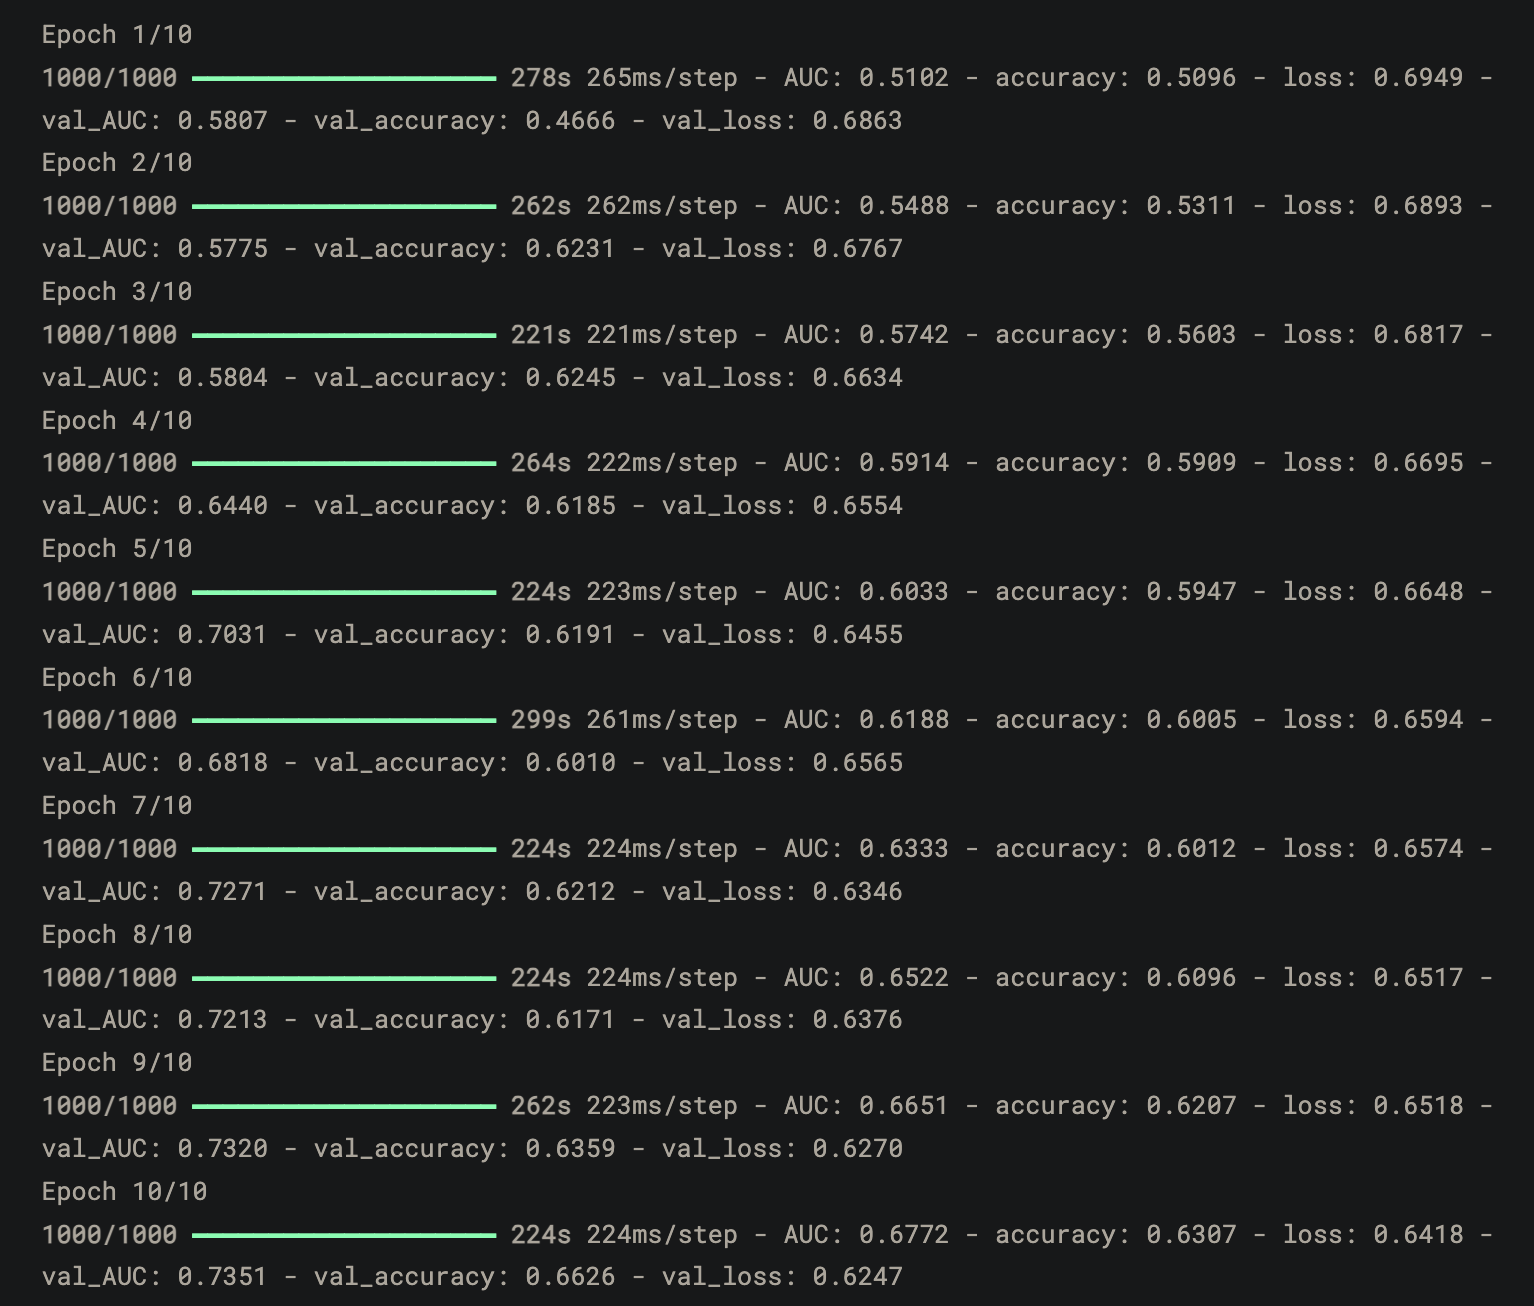

As can be seen above the loss reduced but it reduced very slowly. It means our step size is too small. Below I will increase the step size and that should help.

In [ ]:
checkpoint_callback = ModelCheckpoint('model_checkpoint_transfer_learning.keras', save_best_only=True)
model_transfer_learning.compile(optimizer=Adam(learning_rate=0.01), 
                                loss="binary_crossentropy",
                                metrics=["accuracy", "AUC"])

history2 = model_transfer_learning.fit(
    X, y,
    batch_size=32, epochs=50,
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint_callback]
)

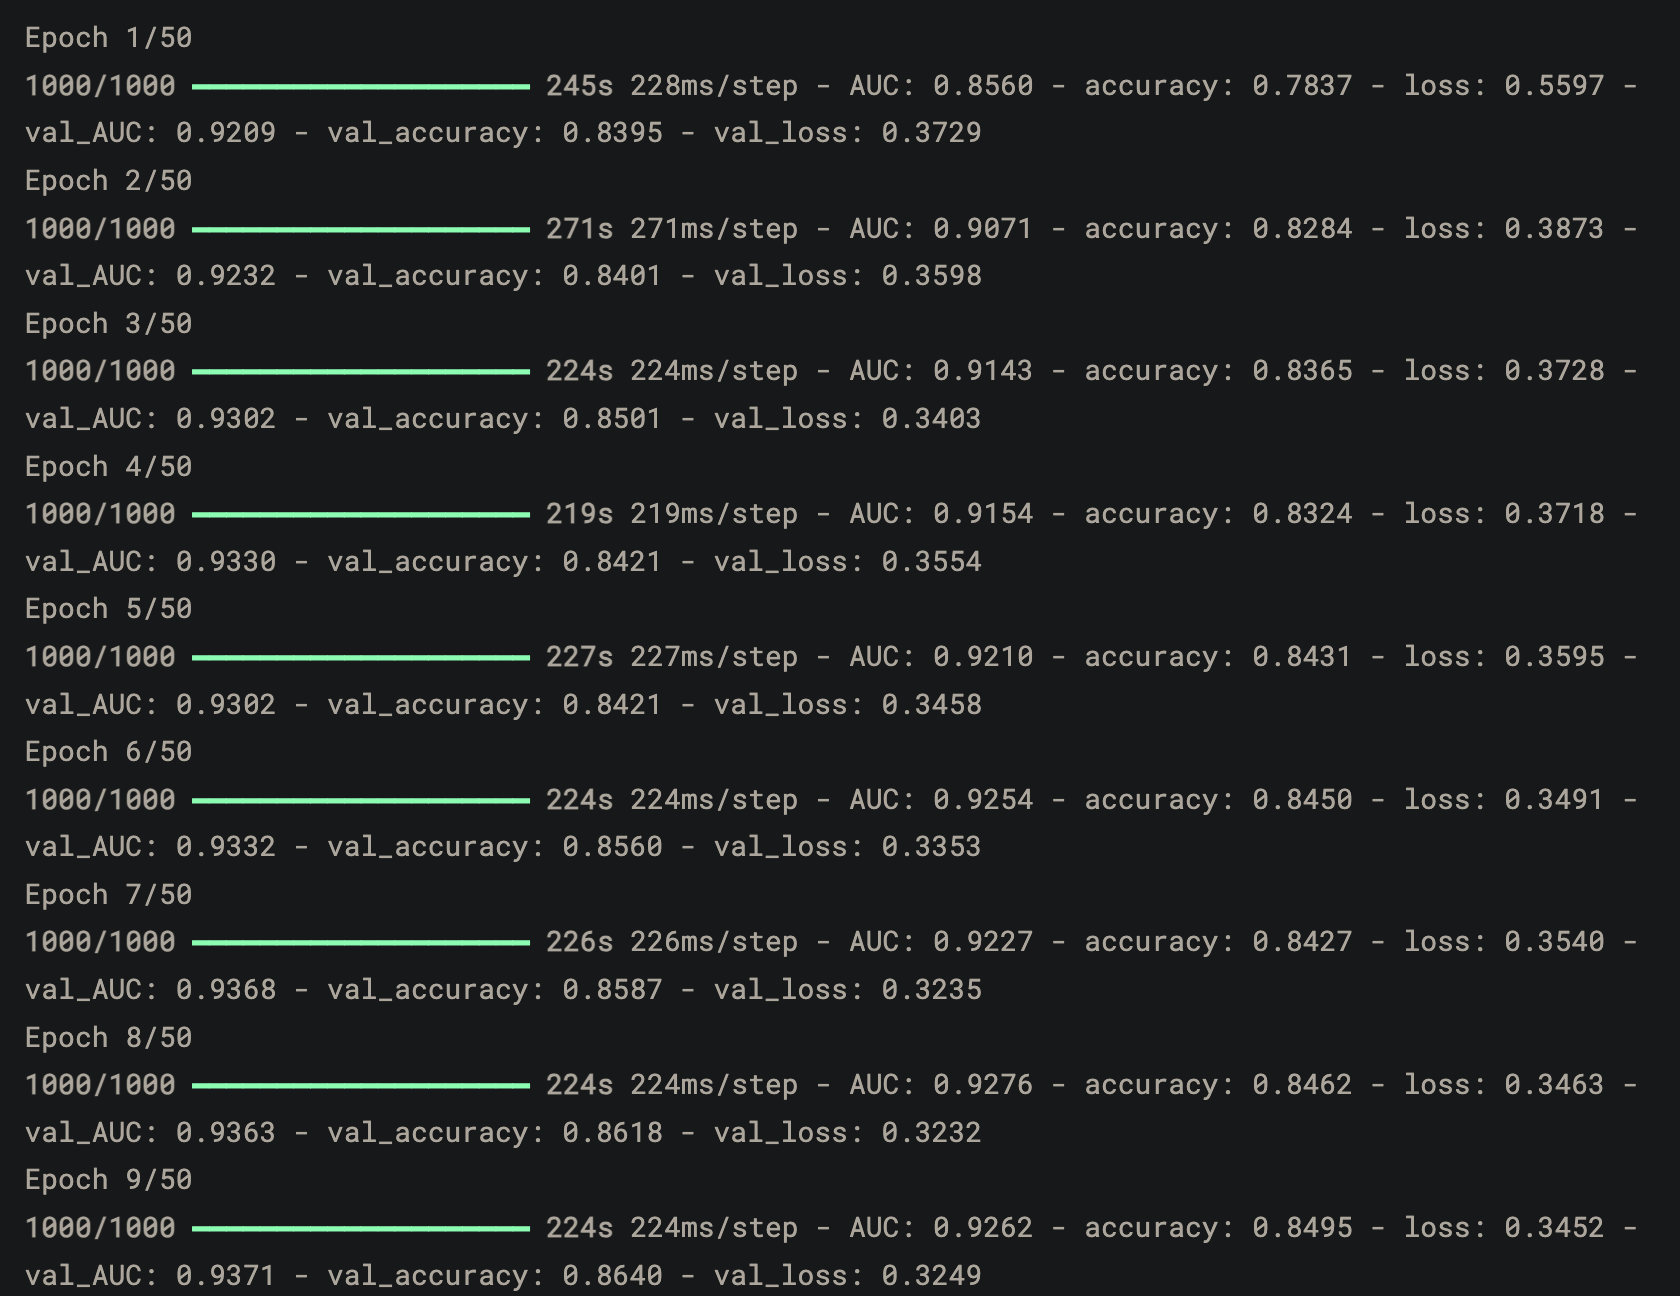
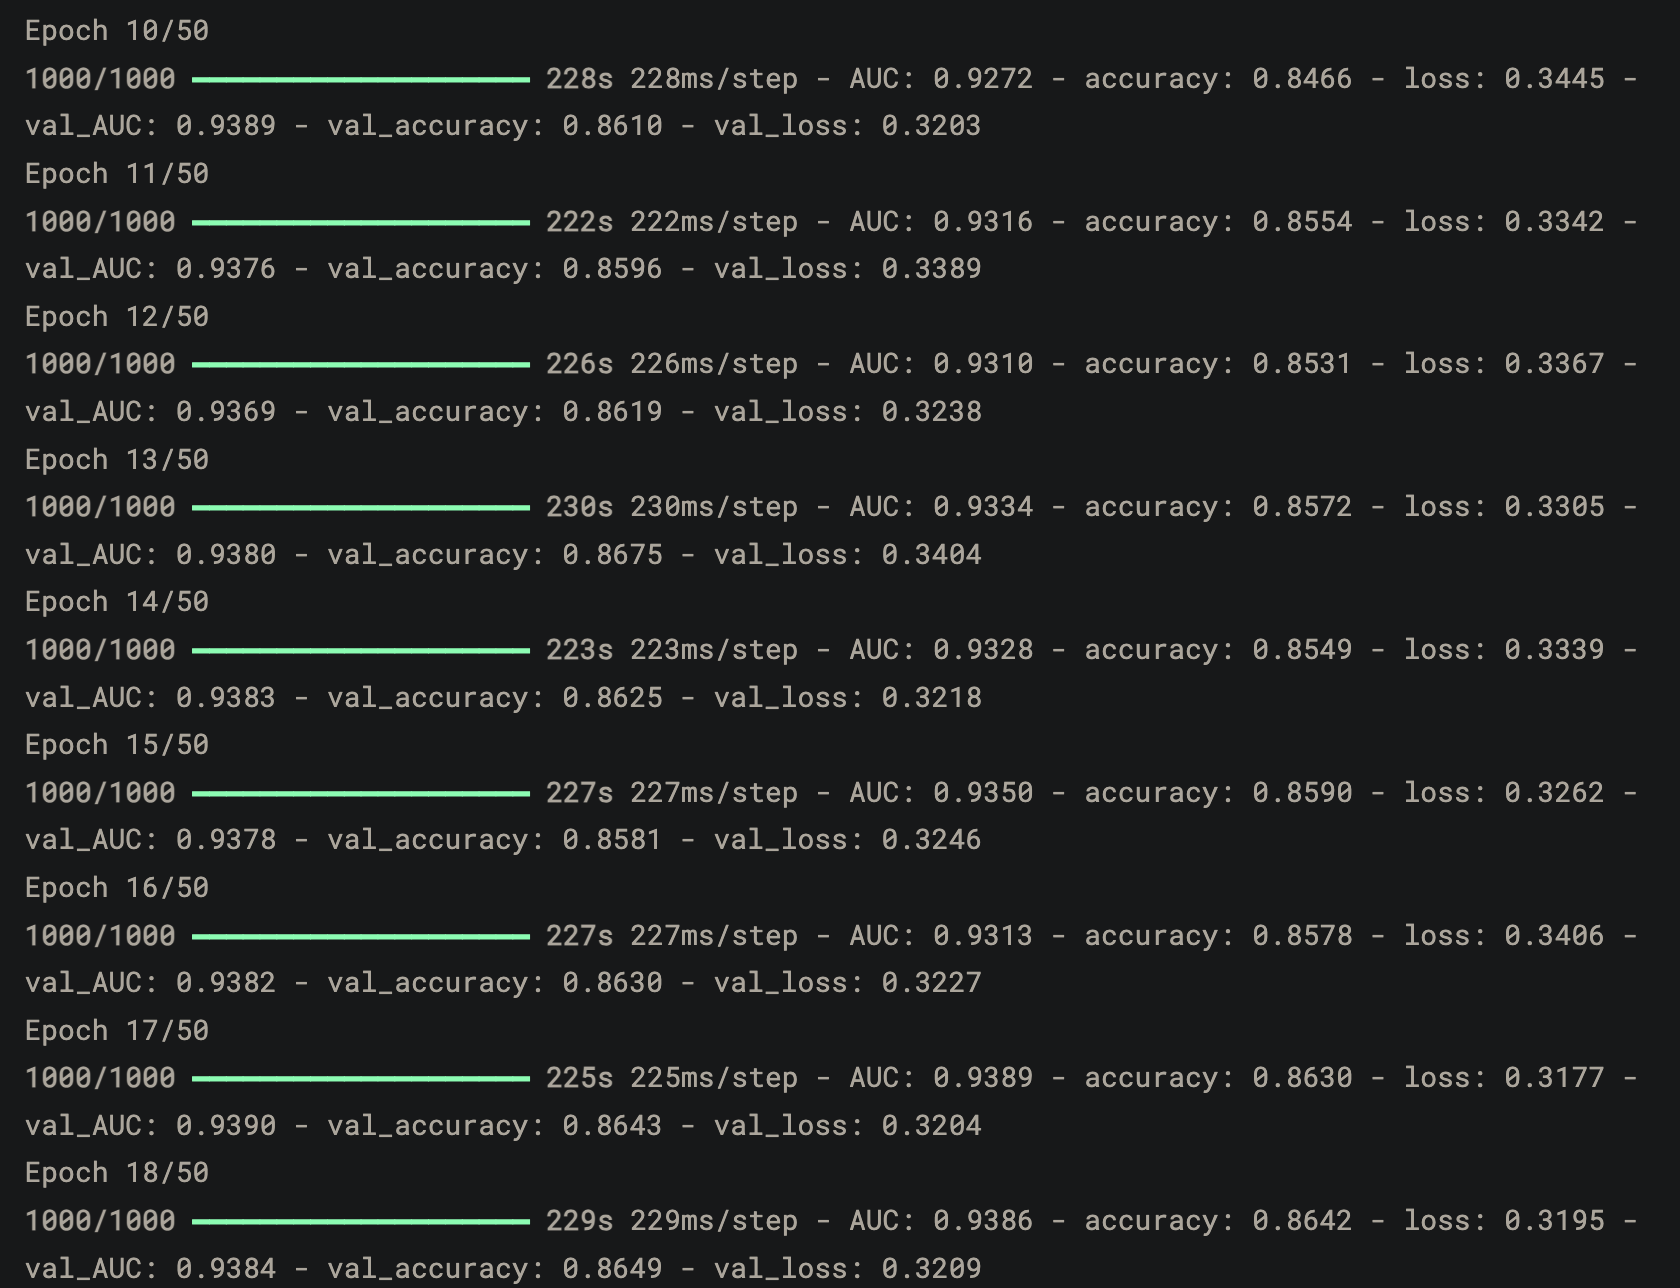
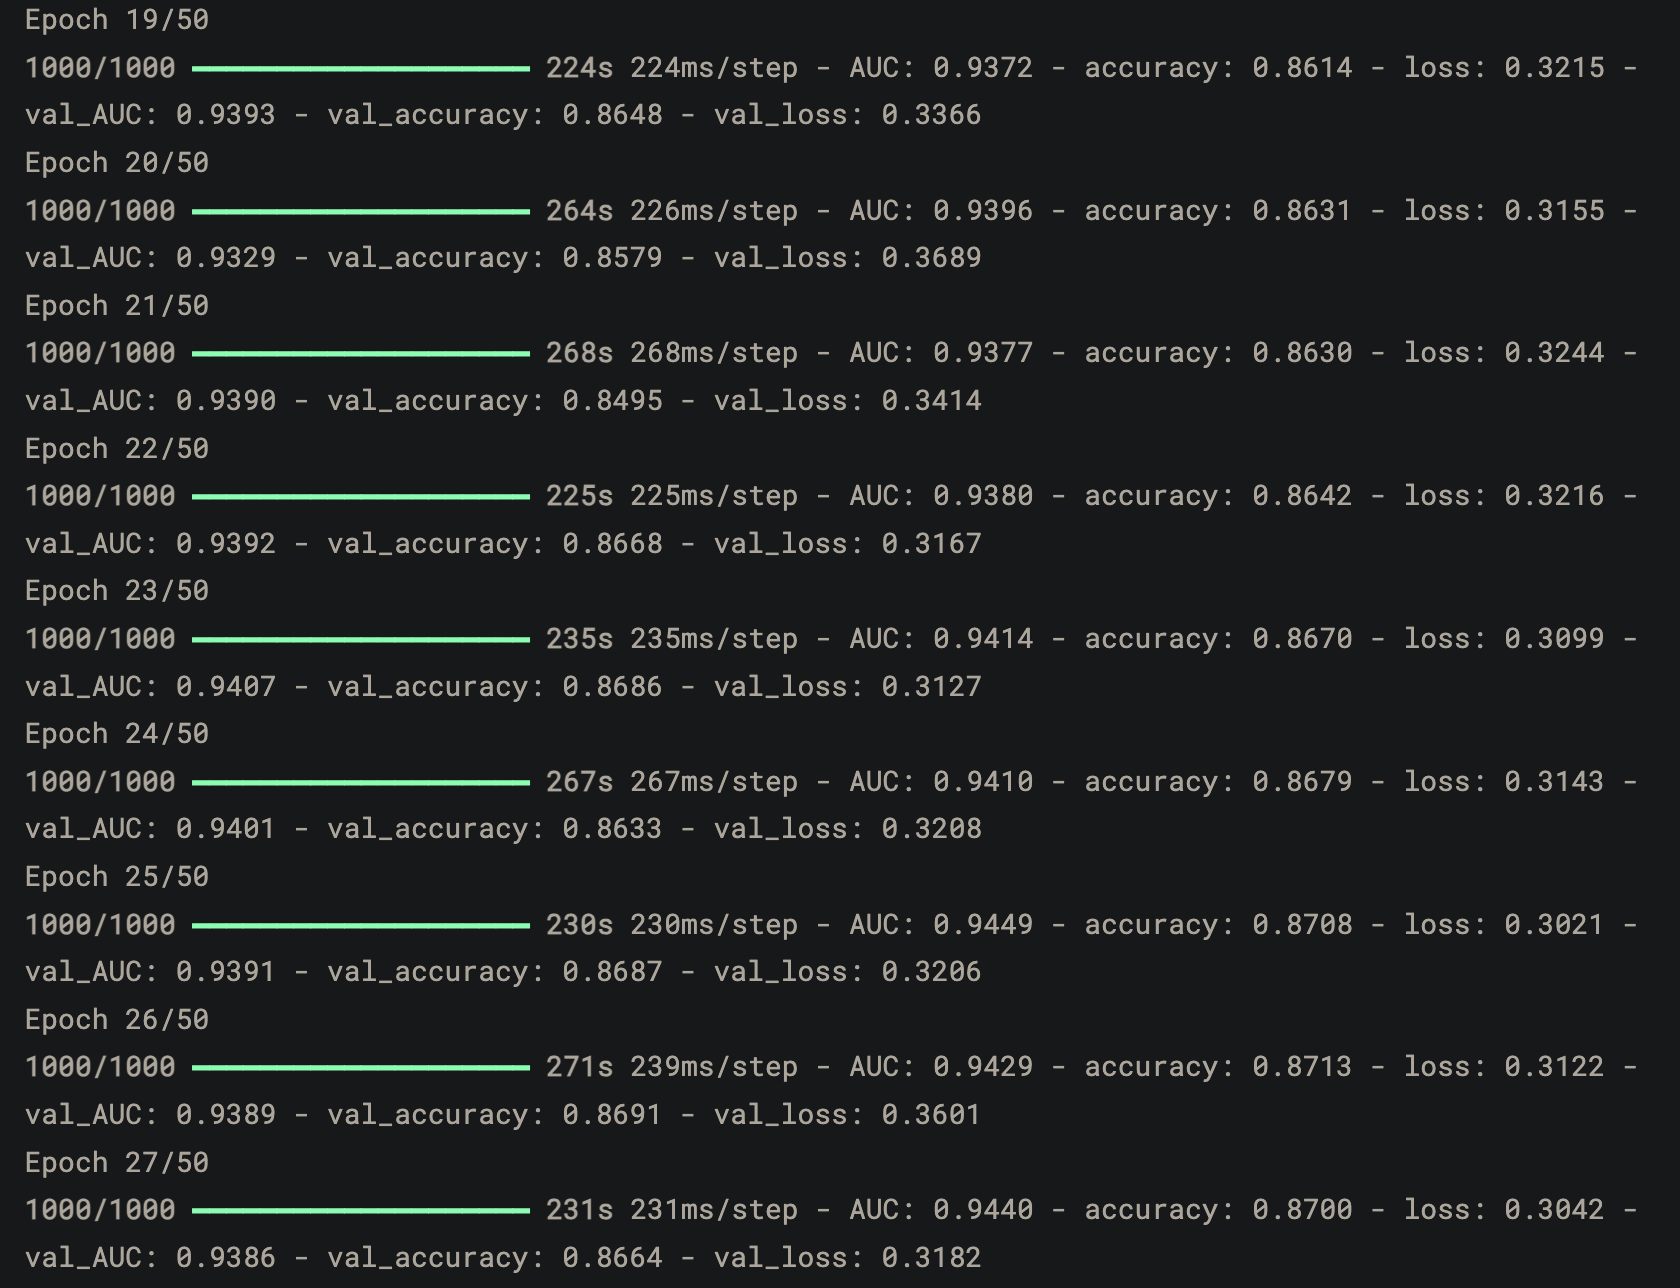
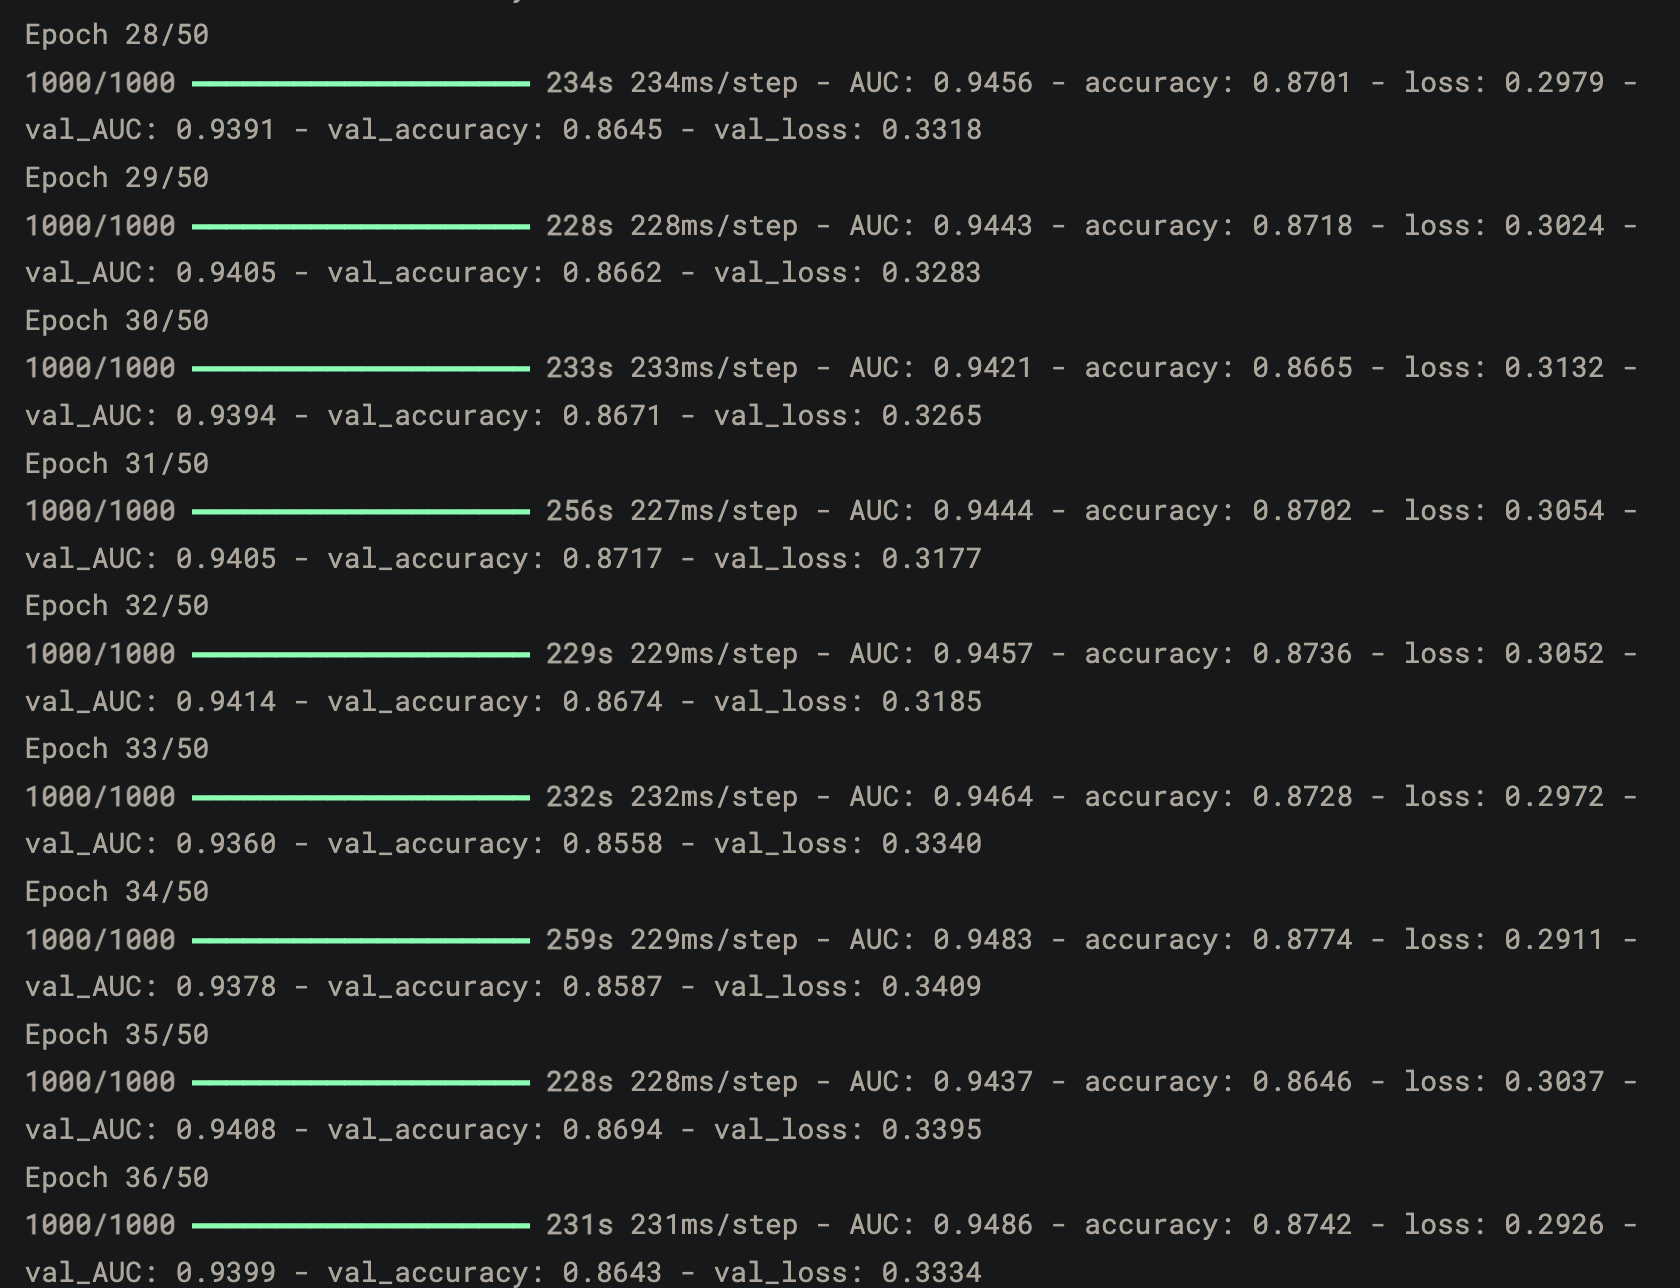
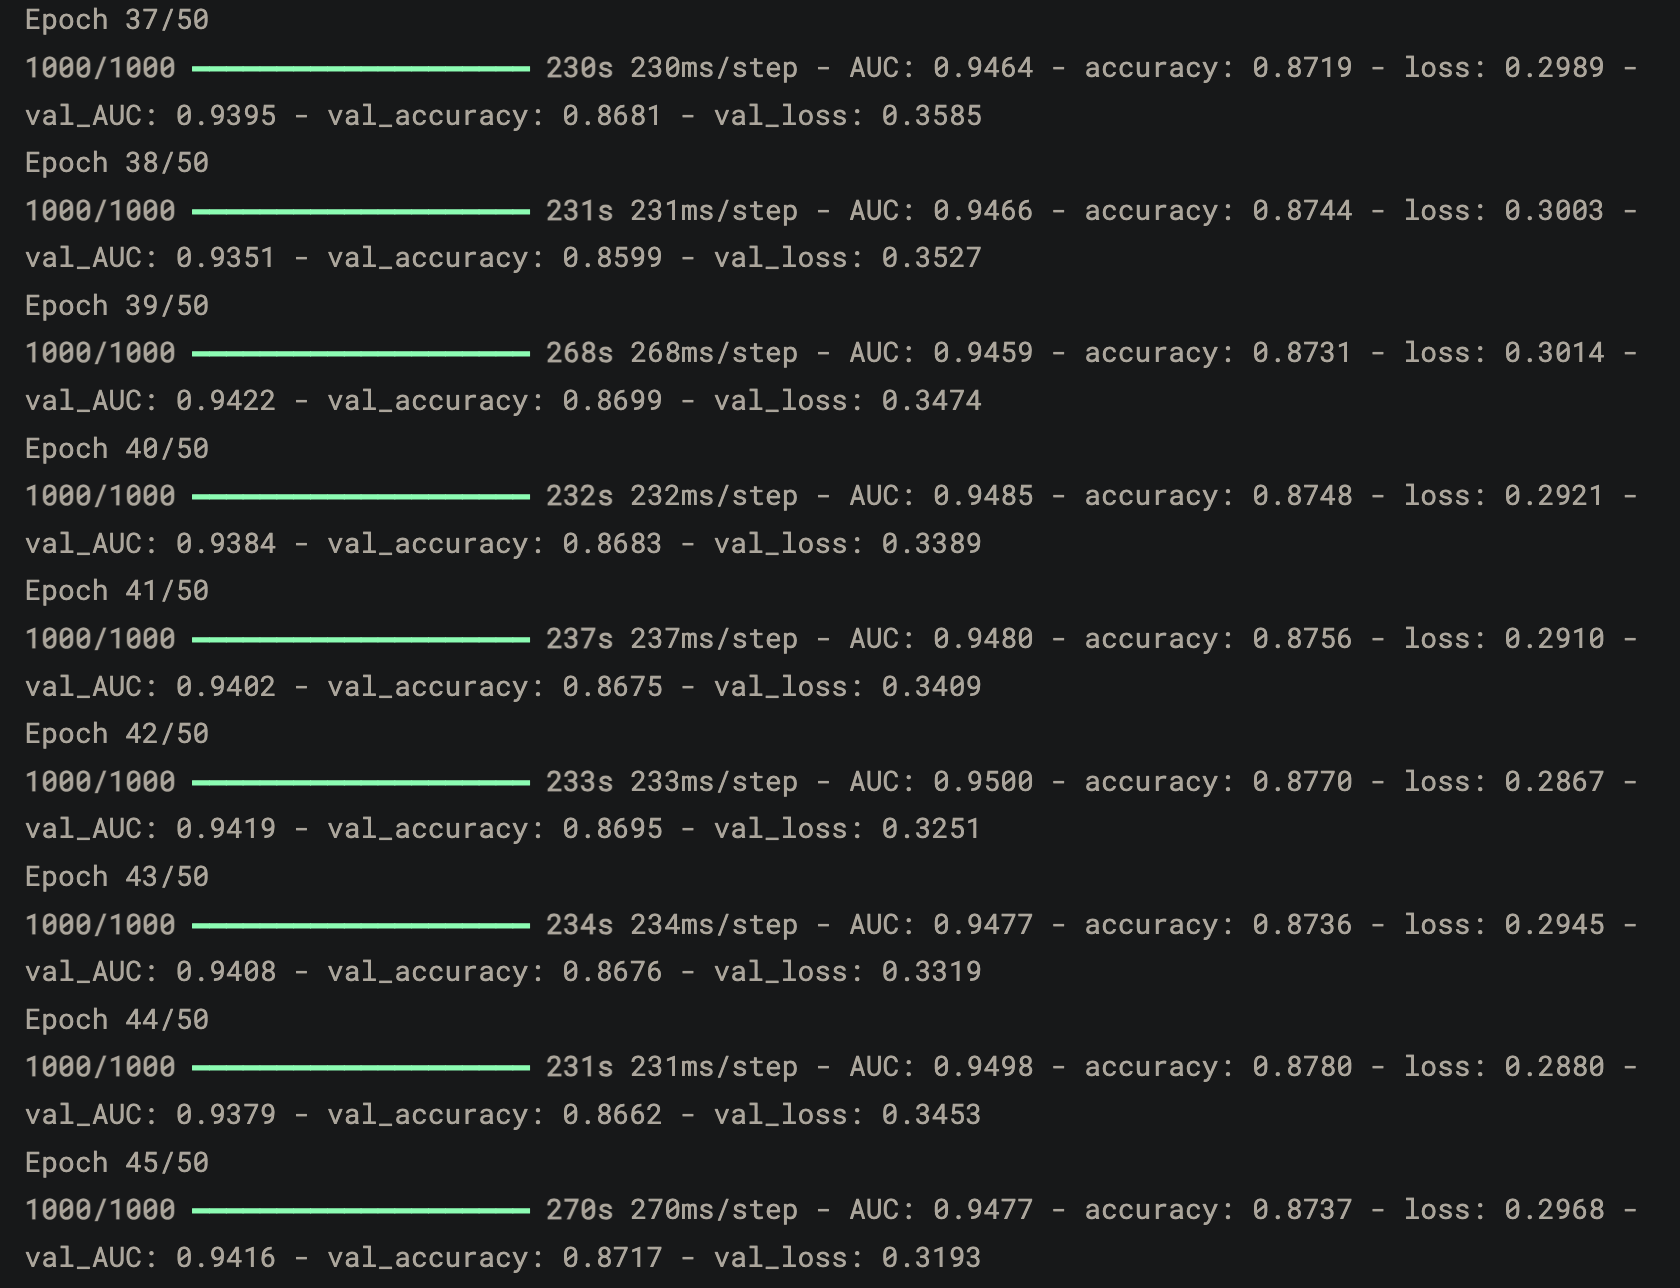
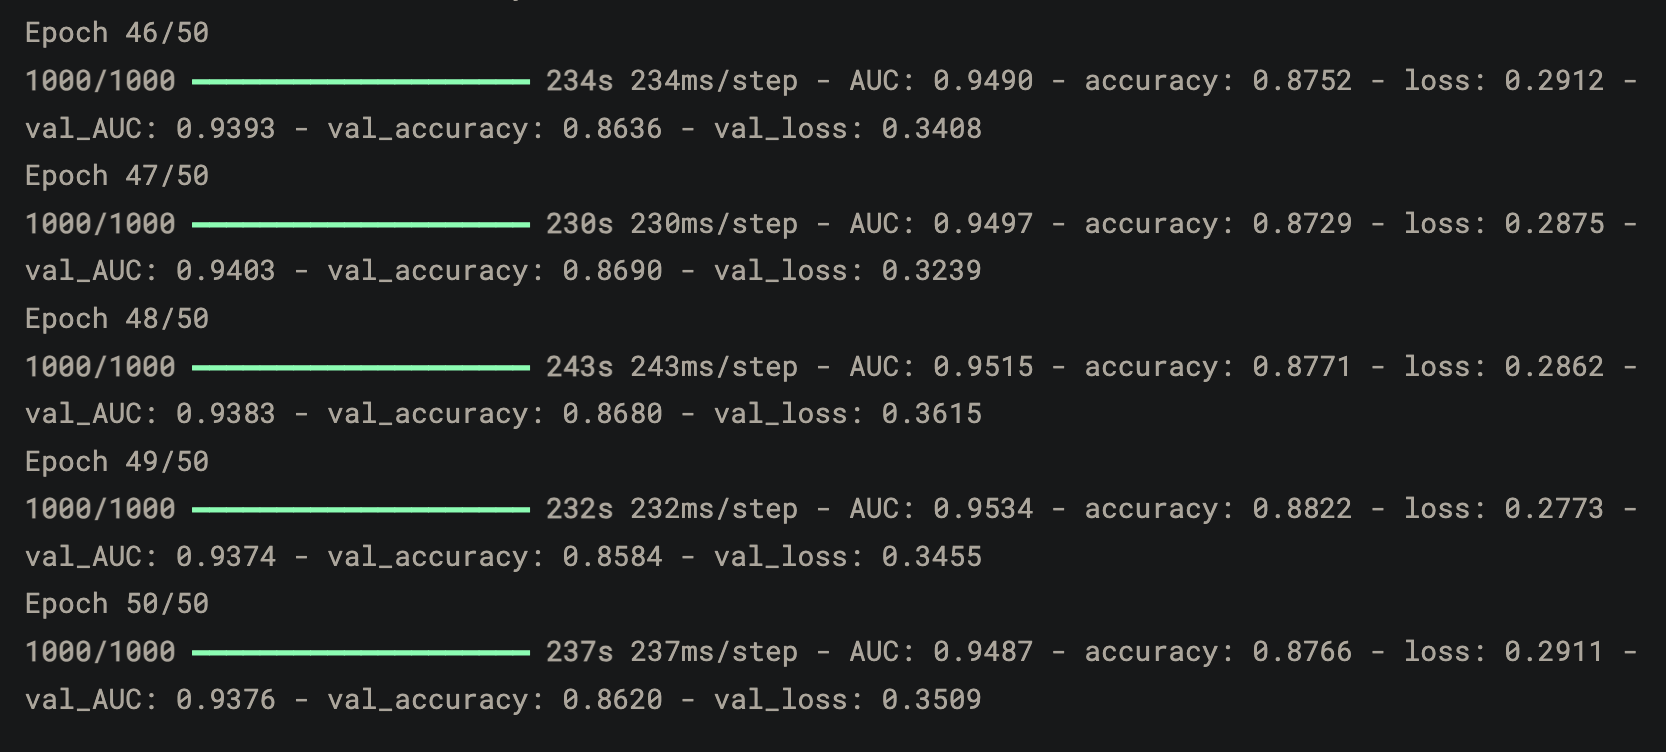
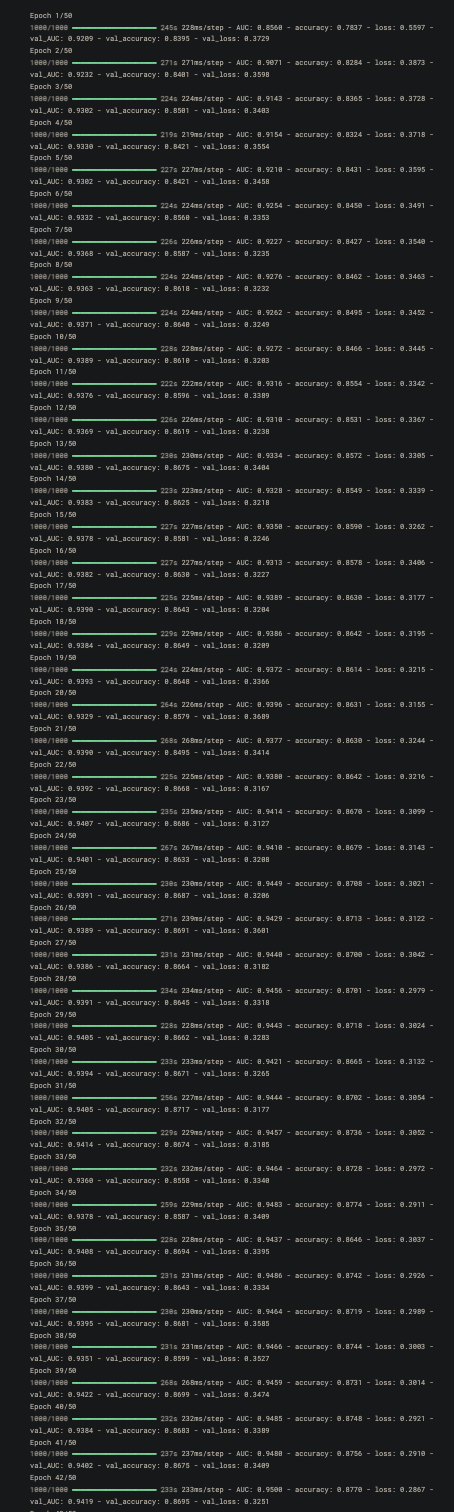
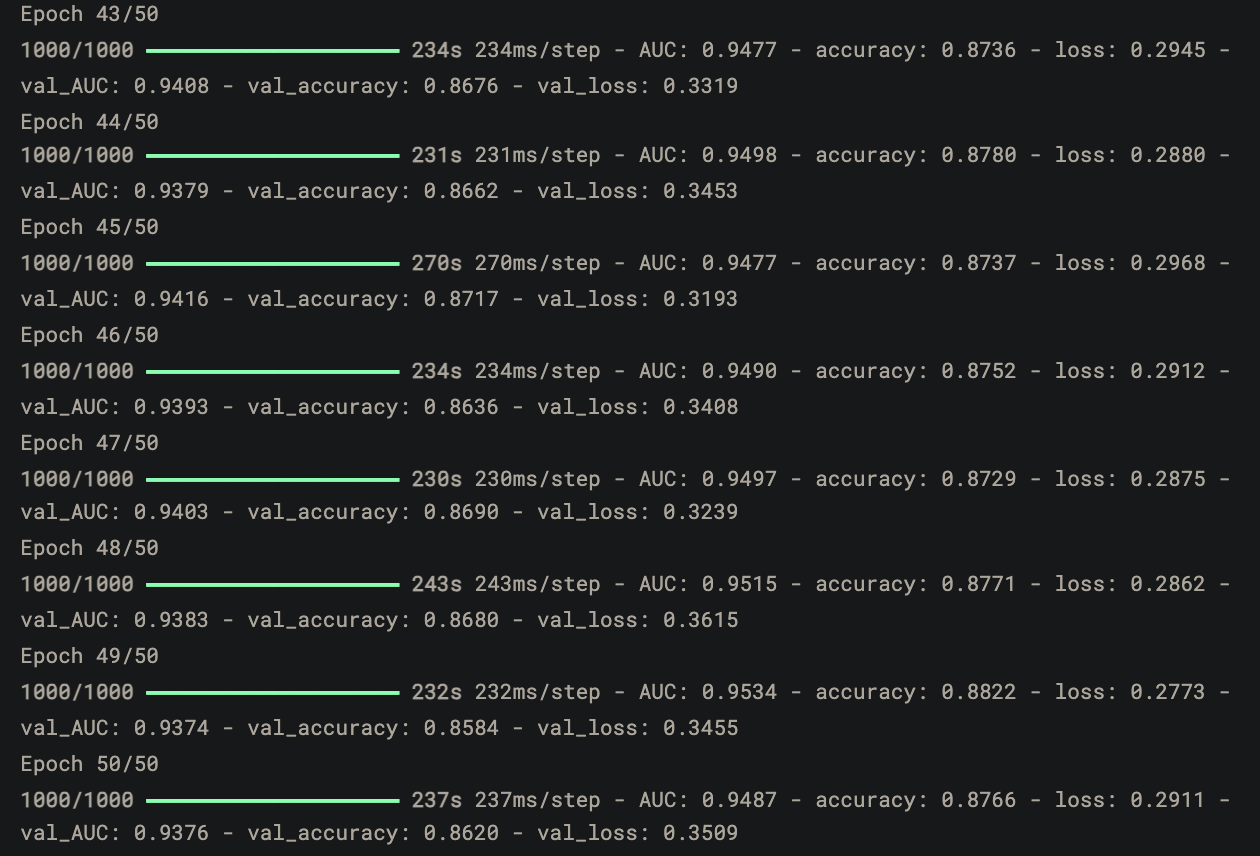
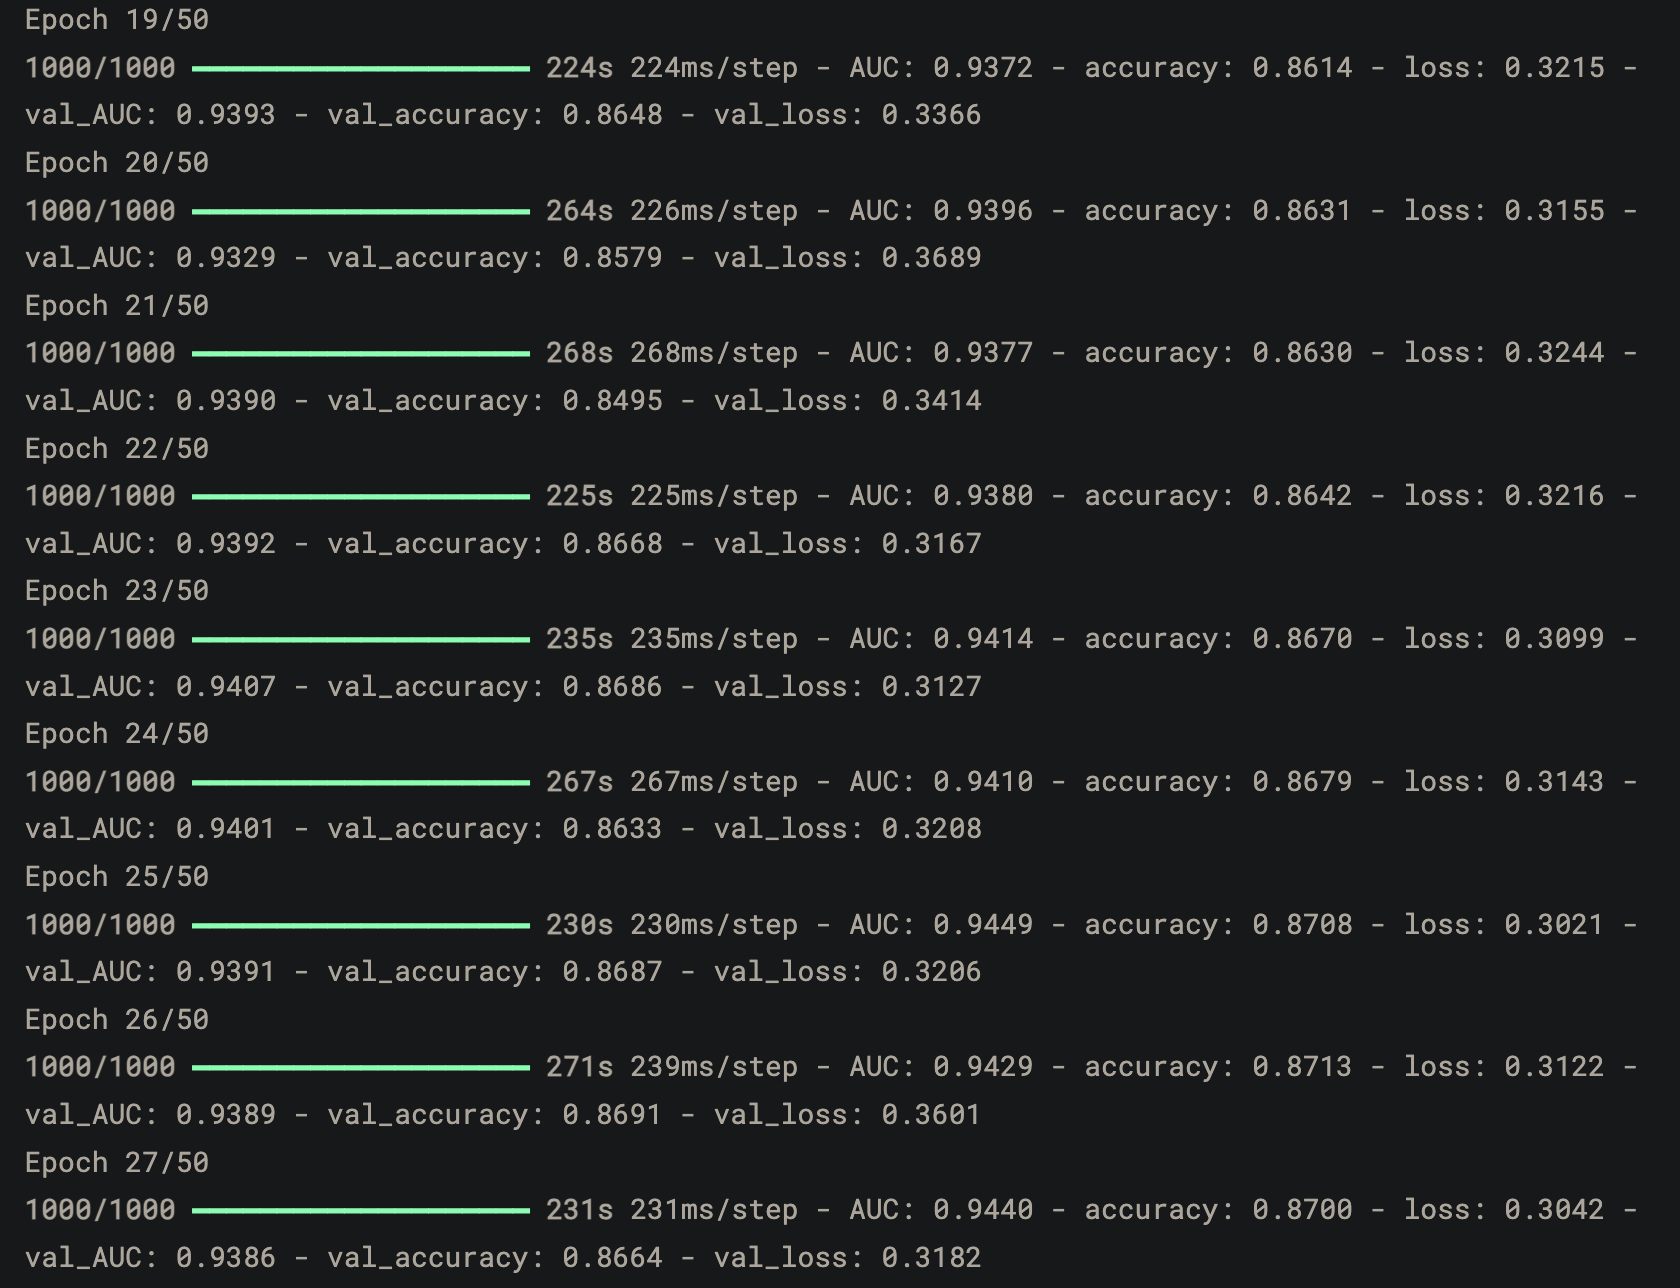

In [ ]:
model_transfer_learning.save("cancer_detection_model_transfer_learning.h5")

In [ ]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

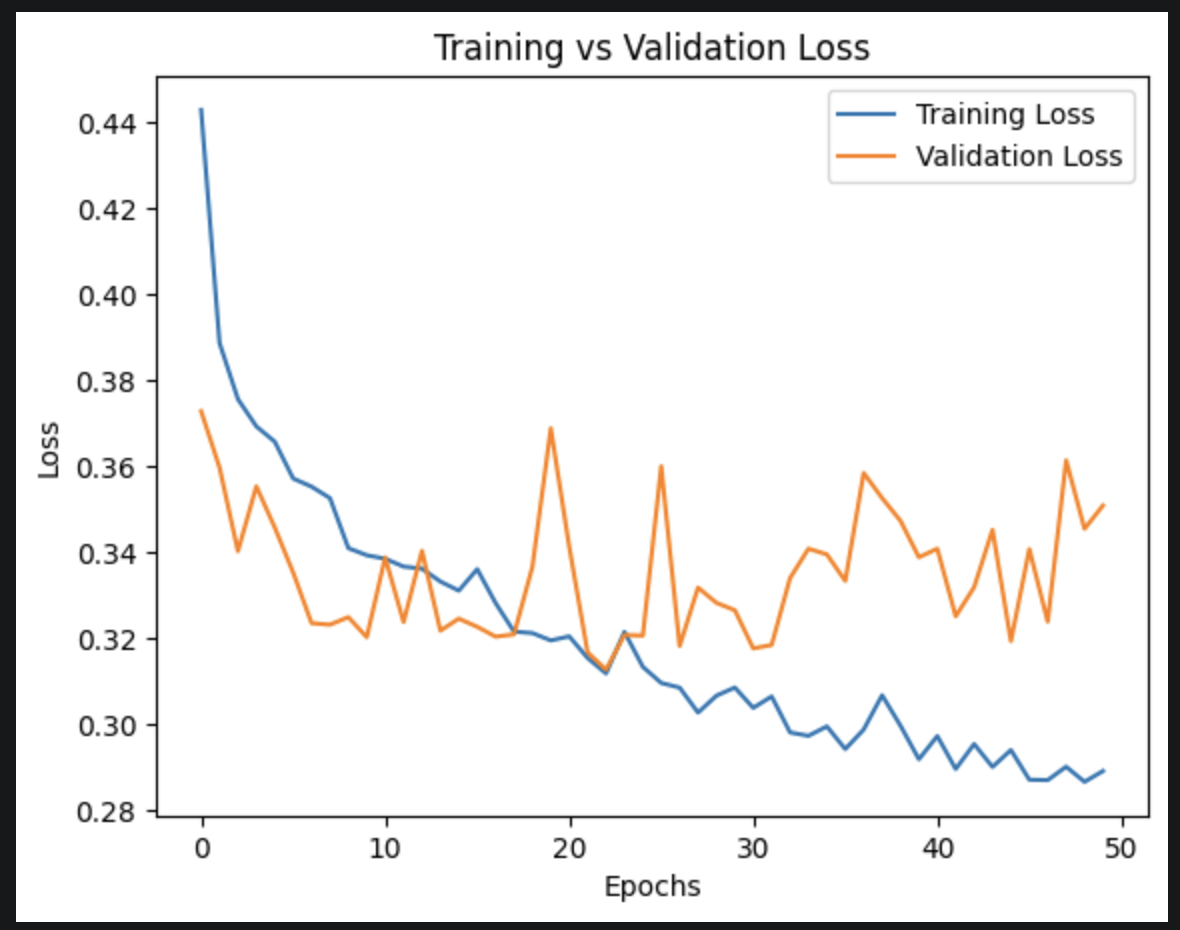

In [19]:
from tensorflow.keras.models import load_model

model_arch1_2 = load_model('/kaggle/input/best_model_arch1_2.keras/keras/default/1/model_checkpoint_arch1_2.keras')
model_transfer_learning = load_model('/kaggle/input/transfer_learning_model_checkpoint/keras/default/1/model_checkpoint_transfer_learning (1).keras')

In [21]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from PIL import Image

class NormalizedTestImageGenerator(Sequence):
    def __init__(self, image_ids, image_dir, batch_size=32):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.means = np.array([179.09645477, 138.07895266, 177.63314542])
        self.stds = np.array([59.77747839, 70.58780024, 53.95306808])

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []

        for img_id in batch_ids:
            img_path = os.path.join(self.image_dir, img_id)
            img = Image.open(img_path)
            img = np.array(img).astype(np.float32)

            # Normalize with mean and std
            img = (img - self.means) / self.stds

            batch_images.append(img)

        return np.array(batch_images)

In [3]:
# test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
# fnames = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.tif')]
# X_test = np.array([load_image(img_path=f_name) for f_name in fnames])

In [10]:
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
image_ids = [fname for fname in os.listdir(test_dir) if fname.endswith('.tif')]

test_gen = NormalizedTestImageGenerator(image_ids, test_dir, batch_size=32)

In [5]:
y_pred_model_arch1_2 = model_arch1_2.predict(test_gen, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1317s 733ms/step


In [13]:
import pandas as pd
import numpy as np

def save_submission_file(y_pred, submission_file_name):
    y_pred_labels = (y_pred > 0.5).astype(int).flatten()    
    df = pd.DataFrame({
        'id': [img_id[:-4] for img_id in image_ids],
        'label': y_pred_labels
    })
    df.to_csv(submission_file_name+'.csv', index=False)

In [14]:
save_submission_file(y_pred_model_arch1_2,'model_arch1_2_submission')

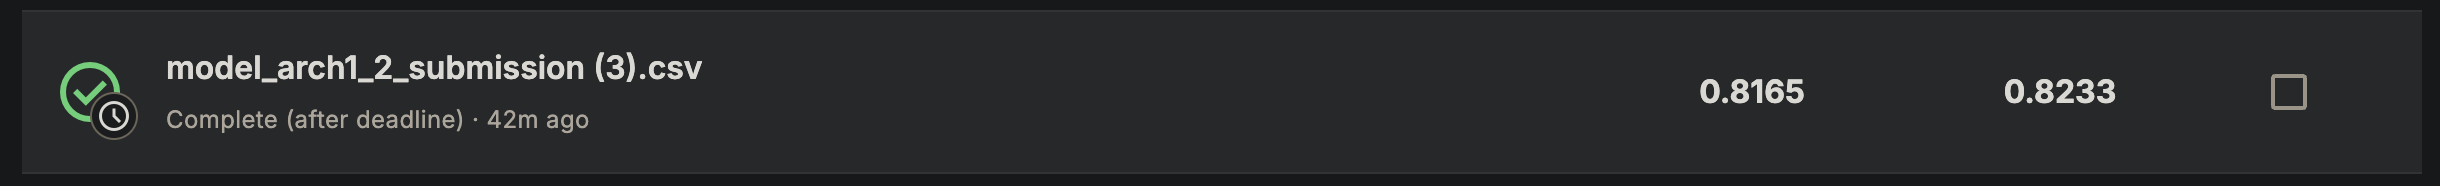

In [23]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from PIL import Image

class TestImageGenerator(Sequence):
    def __init__(self, image_ids, image_dir, batch_size=32):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []

        for img_id in batch_ids:
            img_path = os.path.join(self.image_dir, img_id)
            img = Image.open(img_path)
            img = np.array(img).astype(np.float32)
            batch_images.append(img)

        return np.array(batch_images)

In [27]:
test_gen_transfer_learning = TestImageGenerator(image_ids, test_dir, batch_size=32)
y_pred_transfer_learning = model_transfer_learning.predict(test_gen_transfer_learning, verbose=1)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 401s 222ms/step


In [28]:
save_submission_file(y_pred_transfer_learning,'model_transfer_learning_submission')

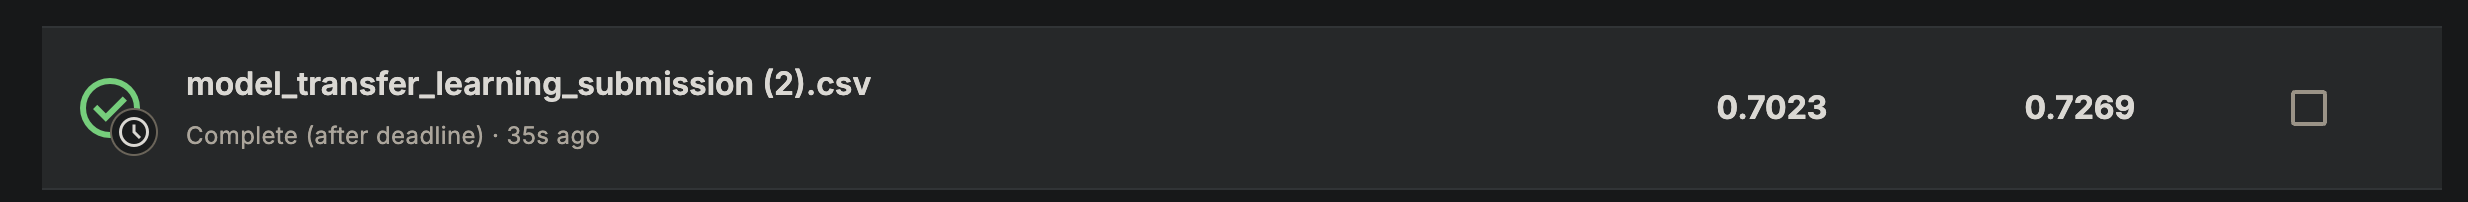

## Conclusion

1. I explored 2 different type of models - Simple CNN mode and Transfer learning (fine tuning EfficentNet model).
2. On the training set, Simple CNN model performed better with a top validation accuracy of 96.45% and training accuracy of 96.94% as compared to Transfer learning model which had a top validation accuracy of 95.34% and training accuracy of 88.22%.
3. On the test set, Simple CNN outperformed Transfer learning model. It got a score of 0.8233 whereas the transfer learning model got 0.7269.
4. Transfer learning model didn't perform as good because the base model was EfficientNetB0 whose weights we froze. This model is trained on ImageNet dataset which does not have medical images. Additionally, the weights of base model were frozen and fine tuning the transfer learning model on the last few layers didn't give us the best recipe for success. The model still performed decently good.
5. In contrast, the simple CNN, being fully trainable, was better able to adapt to the specific patterns in images to detect the tumor.

Improvement ideas:
1. Since simple CNN architecture worked well, It would be good to explore more complex CNN models, they would be able to identify complex patters to detect the tumor.
2. For transfer learning, having a base model which is trained on medical images should help. I used EfficientNetB0 as my base model which is trained on ImageNet database which is a database of natural images and not medical images.
3. Having more compute and memory resources so that these models can be trained on the entire dataset (I had to sample 30k images becase of shortage of resources) would help train the models better.